In [ ]:
#Primero conectemos la maquina virtual con el drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
pip install nilearn

In [ ]:
cd /gdrive/Shareddrives/GENSyR /Neurofísica/Proyecto lesiones

/gdrive/Shareddrives/GENSyR /Neurofísica/Proyecto lesiones


In [ ]:
ls

 AAL.csv
 AAL_space-MNI152NLin6_res-1x1x1.nii.gz
'Conectividad funcional'/
 estructural_hammersmith.npy
 funcional_hammersmith.npy
 Hammersmith.csv
 initial_condition.bin
'Ising - Entropia '/
 M2final.npy
 Mfinal.npy
'Redes Estructurales y funcionales- Hubs.ipynb'
'Redes Funcionales - Hubs.ipynb'
 restingstate_functionalconnectivity.npy
 Tractografia/
'Untitled0 (1).ipynb'
 Untitled0.ipynb


In [ ]:
#se importan librerias y se cargan las matrices con numpy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import random
import pickle
import time
#carguemos las matrices estructural y funcional
estructural1 = np.load("estructural_hammersmith.npy")
funcional = np.load("funcional_hammersmith.npy")
# dada la gran diferencia en cantidad de tractos es necesario aplicar el logaritmo para linealizar los datos
estructural = np.log1p(estructural1)
#Se hace la diagonal igual a 0 para las dos matrices 
for i in range(len(estructural)-1):
  estructural[i+1][i+1] = 0
  funcional[i][i] = 0

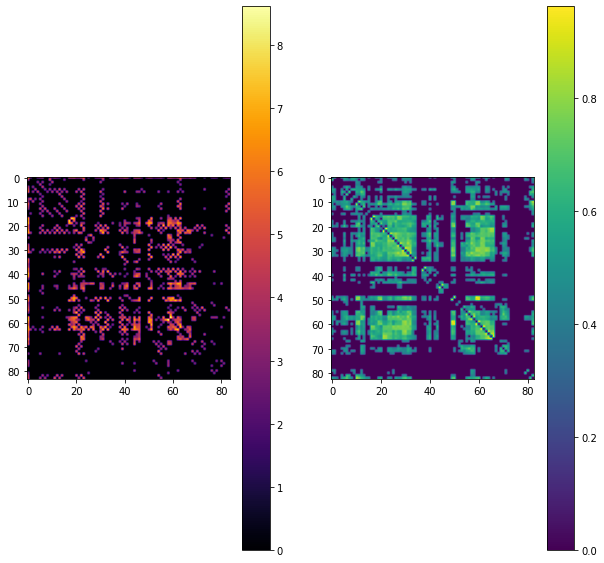

In [ ]:
#Definamos el threshold que se le aplicará a las matrices
estructural_threshold = 3
funcional_threshold = 0.4

#apliquemos el threshold
estruc = estructural*(estructural > estructural_threshold)
func = funcional*(funcional > funcional_threshold)
#ploteemos
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(estruc,cmap = "inferno")
plt.colorbar()
plt.subplot(122)
plt.imshow(func)
plt.colorbar()


In [ ]:
#creamos el grafo y removemos los selfloops y la parcela nula
g = nx.convert_matrix.from_numpy_array(estruc)
g.remove_node(0)
g.remove_edges_from(nx.selfloop_edges(g))

In [ ]:
#Normalicemos la matriz estructural
maximo = np.max(estruc)
estruc = estruc/maximo

#%% Ahora establezcamos y guardemos la condición inicial
# Creemos el estado inicial del sistema aleatoriamente
for i in g.nodes():
  g.nodes[i]['state'] = 1 if random.random()< 0.5 else -1
#Creemos y guardemos una lista con las condiciones iniciales
prueba2 = []
for i in g.nodes():
    prueba2.append([g.nodes[i]["state"]])
with open("initial_condition.bin","wb") as output:
    pickle.dump(prueba2,output)

NameError: ignored

In [ ]:
#%% Cargemos las condiciones iniciales y exploremos los posibles estados
#cargemos las condiciones iniciales en la lista w
with open("initial_condition.bin","rb") as data:
    w = pickle.load(data)
#carguemos el estado de los nodos acorde a las condiciones iniciales cargadas
for i in range(83):
    g.nodes[i+1]['state'] = w[i][0]
    

#acá empieza el codigo del algoritmo metroplolis
T = 19.5 #definimos la temperatura
resistencia = 17 #definimos la constante de la que depende el costo de activación de cada parcela
iteraciones = 100000 #numero de iteraciones
acople = 2 #acople global que multiplica a la matriz de adyaecencia
inicio = time.time()

time_series = np.zeros((len(g.nodes()),iteraciones))#array en el que llenaremos las series de tiempo
E = np.zeros(iteraciones) # array que llenaremos con las energias

# iteremos
for i in range(iteraciones):
    if i%500 == 0 and i != 0: #cada 500 iteraciones swipeamos todos los spins para evitar el algoritmo se quede atascado en atractores
        for nodo in g.nodes():
            if g.nodes[nodo]['state'] == 1:
                g.nodes[nodo]['state'] = -1
            else:
                g.nodes[nodo]['state'] = 1
                
    #desde aca empieza el muestreo
    n = np.random.choice(g.nodes()) #seleccionamos un nodo aleatoriamente
    #print(n)
    s = (acople/2)*np.sum(g.nodes[j]['state']*estruc[n,j] for j in g.neighbors(n)) #hallamos el valor de spin de sus vecinos pesados por la fuerza del enlace con el nodo n
    #Creo que realmente no se hace el swip a ningún spin, lo que es raro, por lo que no entiendo como aplica el cambio de energia entonces 
    de = s*(g.nodes[n]['state']-1) + (1-2*g.nodes[n]['state'])*resistencia/12 #calculamos la diferencia de energía    

    #----------------- cambio de energía corregido-------------- (revisar xd)
    s = (acople/2)*2*np.sum(g.nodes[j]['state']*estruc[n,j] for j in g.neighbors(n)) #hallamos el valor de spin de sus vecinos pesados por la fuerza del enlace con el nodo n y multiplicamos x2
    de = s*(g.nodes[n]['state']*2) + (1/2)*(-2)*g.nodes[n]['state']*resistencia   


    if de <0: #si la diferencia es negativa se acepta el swip
        if g.nodes[n]['state'] == 1:
             g.nodes[n]['state'] = -1
        else: 
             g.nodes[n]['state'] = 1

    else: #si la diferencia es positiva se acepta el swip con cierta probabilidad
        #p = (np.exp(-de/T))/(1 + np.exp(-de/T)) #probabilidad segun Glauber
        p = np.exp(-de/T) #probabilidad segun DECO
        number = random.random()
        if number < p:
            if g.nodes[n]['state'] == 1:
                 g.nodes[n]['state'] = -1
            else:
                 g.nodes[n]['state'] = 1
    #ahora vamos a guardar la energia del estado y el valor de spin de todos los nodos
    suma = 0
    for nodes in g.nodes():
        energia = g.nodes[nodes]['state']*resistencia/2 -(acople/2)*g.nodes[nodes]['state']*np.sum(g.nodes[vecinos]['state']*estruc[nodes,vecinos] for vecinos in g.neighbors(nodes))
        suma = suma + energia
    E[i] = suma
    for k in g.nodes():
        time_series[k-1,i] = g.nodes[k]["state"]


w = time_series
# tiempo que demoro en correr el algoritmo
fin = time.time()
tiempo = fin-inicio
print(tiempo,"tiempo")

#calculemos la probabilidad de los estados a partir de sus energías
probabilidad = np.exp(-E/T)
#calculemos la función de partición
Z = np.sum(probabilidad)
probabilidad = probabilidad/Z
#y finalmente calculemos la entropia
entropias = probabilidad*np.log(probabilidad)
entropia = -np.sum(entropias)
print(entropia)



"""
# Transpongamos el array para usar la función de nilearn connectome
l = w
trans = list(map(list, zip(*l)))
# creemos la matriz de correlaciones con nilearn
from nilearn import connectome
#creamos la función para correlación
correlation_measure = connectome.ConnectivityMeasure(kind='correlation')

#creamos las matrices usando la función
trans = np.array(trans) #hagamos un array de la lista donde estan las series de tiempo transpuestas
simulation_matrix = correlation_measure.fit_transform([trans])
simulation_matrix = simulation_matrix[0]

#hagamos la diagonal 0
for i in range(1,len(simulation_matrix)):
  simulation_matrix[i][i] = 0


#grafiquemos la matriz simulada
plt.figure()
plt.imshow(simulation_matrix,vmin = -0.1, vmax = 1)
plt.colorbar()
"""


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


245.22674107551575 tiempo
11.211079357321363


"\n# Transpongamos el array para usar la función de nilearn connectome\nl = w\ntrans = list(map(list, zip(*l)))\n# creemos la matriz de correlaciones con nilearn\nfrom nilearn import connectome\n#creamos la función para correlación\ncorrelation_measure = connectome.ConnectivityMeasure(kind='correlation')\n\n#creamos las matrices usando la función\ntrans = np.array(trans) #hagamos un array de la lista donde estan las series de tiempo transpuestas\nsimulation_matrix = correlation_measure.fit_transform([trans])\nsimulation_matrix = simulation_matrix[0]\n\n#hagamos la diagonal 0\nfor i in range(1,len(simulation_matrix)):\n  simulation_matrix[i][i] = 0\n\n\n#grafiquemos la matriz simulada\nplt.figure()\nplt.imshow(simulation_matrix,vmin = -0.1, vmax = 1)\nplt.colorbar()\n"